In [1]:
import math
import numpy as np
from IPython.display import clear_output
import pdb
import time

import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from torchdiffeq import odeint_adjoint as odeint
from torch.distributions import MultivariateNormal
use_cuda = torch.cuda.is_available()
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import gc

In [9]:
class BoundingBox():
    ## use like:
    # BB = BoundingBox(z_target);
    # smps = BB.sampleuniform(t_N = 30, x_N = 10, y_N = 11, z_N=12, bbscale = 1.1);
    # smps = BB.samplerandom(N = 10000, bbscale = 1.1);
    
    def __init__(self, z_target_full):
        self.T = z_target_full.shape[0]; 
        self.dim = z_target_full.shape[2];
        
        # min corner, max corner, center
        self.mic = z_target_full.reshape(-1,self.dim).min(0)[0];
        self.mac = z_target_full.reshape(-1,self.dim).max(0)[0]; 
        self.C = (self.mic+self.mac)/2; 
        
    def extendedBB(self, bbscale):
        # extended bounding box.
        emic = (self.mic-self.C)*bbscale+self.C; 
        emac = (self.mac-self.C)*bbscale+self.C; 
        return emic, emac;
        
    def sampleuniform(self, t_N = 30, x_N = 10, y_N = 11, z_N = 12, bbscale = 1.1):
        [eLL,eTR] = self.extendedBB(bbscale);
        
        tspace = torch.linspace(0, self.T-1, t_N);
        xspace = torch.linspace(eLL[0], eTR[0], x_N);
        yspace = torch.linspace(eLL[1], eTR[1], y_N);
        if self.dim == 3:
            zspace = torch.linspace(eLL[2], eTR[2], z_N);
            xgrid,ygrid,zgrid,tgrid=torch.meshgrid(xspace,yspace,zspace,tspace);
            z_sample = torch.transpose(torch.reshape(torch.stack([tgrid,xgrid,ygrid,zgrid]),(4,-1)),0,1).to(device);
        else:
            xgrid,ygrid,tgrid=torch.meshgrid(xspace,yspace,tspace);
            z_sample = torch.transpose(torch.reshape(torch.stack([tgrid,xgrid,ygrid]),(3,-1)),0,1).to(device);
        
        return z_sample.to(device)
    
    def samplerandom(self, N = 10000, bbscale = 1.1):
        [eLL,eTR] = self.extendedBB(bbscale);
        # time goes from 0 to T-1
        dT = torch.Tensor([self.T-1]).to(device); # size of time begin to end
        TC = torch.Tensor([(self.T-1.0)/2.0]).to(device); # time center
        
        z_sample = torch.rand(N, self.dim + 1).to(device)-0.5;
        deltx = torch.cat((dT,eTR-eLL))
        z_sample = deltx*z_sample + torch.cat((TC,self.C));

        return z_sample
    
# fourier features mapping
class InputMapping(nn.Module):
    def __init__(self, d_in, n_freq, sigma=2):
        super().__init__()
        self.B = nn.Parameter(torch.randn(n_freq, d_in) * sigma, requires_grad=False).to(device)
        self.d_in = d_in;
        self.n_freq = n_freq;
#         self.d_out = n_freq * 2 + d_in - 1;
        self.d_out = n_freq * 2 + d_in;
    def forward(self, xi):
        # x = (xi/(2*np.pi)) @ self.B.T
        x = (2*np.pi*xi) @ self.B.T
        # pdb.set_trace()
        # return torch.cat([torch.sin(x), torch.cos(x), xi[:,[1, 2]]], dim=-1)
        return torch.cat([torch.sin(x), torch.cos(x), xi], dim=-1)

In [10]:
class ODEfunc(nn.Module):
    """
    Calculates time derivatives.

    torchdiffeq requires this to be a torch.nn.Module.
    """
    
    def __init__(self):
        super(ODEfunc, self).__init__()
        # Define network layers.
        n_freq = 10; # frequencies to sample spacetime in.
        Z_DIM = 2; # dimension of vector field.
        imap = InputMapping(Z_DIM, n_freq);
#         pdb.set_trace()
        self.f = nn.Sequential(imap,
                       nn.Linear(imap.d_out, 256),
                       nn.Softplus(),
                       nn.Linear(256, 256),
                       nn.Softplus(),
                       nn.Linear(256, Z_DIM));

    def get_z_dot(self, t, z):
        """z_dot is parameterized by a NN: z_dot = NN(t, z(t))"""
#         if t.dim()==0:
#             t = t.expand(z.shape[0],1);
#         else:
#             t = t.reshape(z.shape[0],1);
#         tz = torch.cat((t,z),1);
#         pdb.set_trace()
        z_dot = self.f(z)
        return z_dot
    
#     def __init__(self, hidden_dims=(64,64)):
#         super(ODEfunc, self).__init__()
#         # Define network layers.
#         n_freq = 15; # frequencies to sample spacetime in.
#         Z_DIM = 2; # dimension of vector field.
#         imap = InputMapping(3, n_freq);
#         dim_list = [imap.d_out] + list(hidden_dims) + [Z_DIM]
#         layers = []
#         layers.append(imap);
#         for i in range(len(dim_list)-1):
#             layers.append(nn.Linear(dim_list[i]+1, dim_list[i+1]))
#         self.layers = nn.ModuleList(layers)

#     def get_z_dot(self, t, z):
#         # pdb.set_trace()
#         """z_dot is parameterized by a NN: z_dot = NN(t, z(t))"""
#         z_dot = z;
#         for l, layer in enumerate(self.layers):
#             # Concatenate t at each layer.
#             tz_cat = torch.cat((t.expand(z.shape[0],1), z_dot), dim=1)
#             z_dot = layer(tz_cat) #add time t into first spot
#             # pdb.set_trace()
#             if l < len(self.layers) - 1 and not l == 0:
#                 #pdb.set_trace()
#                 z_dot = F.softplus(z_dot)
#         return z_dot

    # d z_dot d z. assuming zdot was computed from z. otherwise output is just 0.
    def getJacobians(self, t, z):
        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):            
            z.requires_grad_(True)
            t.requires_grad_(True)
            z_dot = self.get_z_dot(t, z)
            
            # compute jacobian of velocity field. [N,2,2]
            # inputs z_dot.sum() because each z_dot only depends on one z. no cross derivatives. this batches the grad.
            dim = z.shape[1];
            jacobians = torch.zeros([batchsize,dim,dim], dtype=z.dtype, device=z.device);
            for i in range(z.shape[1]):
                 jacobians[:,i,:] = torch.autograd.grad( z_dot[:, i].sum(), z, create_graph=True)[0]
        return z_dot, jacobians
    
    def forward(self, t, state):
        """
        Calculate the time derivative of z and divergence.

        Parameters
        ----------
        t : torch.Tensor
            time
        state : torch.Tensor
            Contains z

        Returns
        -------
        z_dot : torch.Tensor
            Time derivative of z.
        negative_divergence : torch.Tensor
            Time derivative of the log determinant of the Jacobian.
        """
        z = state
        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            t.requires_grad_(True)

            # Calculate the time derivative of z. 
            # This is f(z(t), t; \theta) in Eq. 4.
            z_dot = self.get_z_dot(t, z)
            
        return z_dot

class FfjordModel(torch.nn.Module):
    """Continuous noramlizing flow model."""

    def __init__(self):
        super(FfjordModel, self).__init__()
        self.time_deriv_func = ODEfunc()

    def save_state(self, fn='state.tar'):
        """Save model state."""
        torch.save(self.state_dict(), fn)

    def load_state(self, fn='state.tar'):
        """Load model state."""
        self.load_state_dict(torch.load(fn))


    def forward(self, z, integration_times=None, reverse=False):
        """
        Implementation of Eq. 4.
        We want to integrate both f and the trace term. During training, we
        integrate from t_1 (data distribution) to t_0 (base distibution).
        Parameters
        ----------
        z : torch.Tensor
            Samples.
        integration_times : torch.Tensor
            Which times to evaluate at.
        reverse : bool, optional
            Whether to reverse the integration times.
        Returns
        -------
        z : torch.Tensor
            Updated samples.
        """
        if integration_times is None:
            integration_times = torch.tensor([0.0, 1.0]).to(z)
        if reverse:
            integration_times = _flip(integration_times, 0)
        #print('integration_times',integration_times)
        # Integrate. This is the call to torchdiffeq.
        
        state = odeint(
            self.time_deriv_func, # Calculates time derivatives.
            z, # Values to update.
            integration_times, # When to evaluate.
            method='dopri5', # Runge-Kutta
            atol=1e-5, # Error tolerance
            rtol=2e-5, # Error tolerance
        )
        
        z = state
        return z
    
def _flip(x, dim):
    indices = [slice(None)] * x.dim()
    indices[dim] = torch.arange(x.size(dim) - 1, -1, -1, dtype=torch.long,             device=x.device)
    return x[tuple(indices)]



In [4]:
def make_image(n=10000):
    """Make an X shape."""
    points = np.zeros((n,2))
    points[:n//2,0] = np.linspace(-1,1,n//2)
    points[:n//2,1] = np.linspace(1,-1,n//2)
    points[n//2:,0] = np.linspace(1,-1,n//2)
    points[n//2:,1] = np.linspace(1,-1,n//2)
    np.random.seed(42)
    noise = np.clip(np.random.normal(scale=0.1, size=points.shape),-0.2,0.2)
    np.random.seed(None)
    points += noise
    img, _ = np.histogramdd(points, bins=40, range=[[-1.5,1.5],[-1.5,1.5]])
    return img


class ImageDataset():
    """Sample from a distribution defined by an image."""

    def __init__(self, img, MAX_VAL=4.0, thresh=0):
        img[img<thresh]=0; # threshold to cut empty region of image
        
        h, w = img.shape
        xx = np.linspace(-MAX_VAL, MAX_VAL, w)
        yy = np.linspace(-MAX_VAL, MAX_VAL, h)
        xx, yy = np.meshgrid(xx, yy)
        xx = xx.reshape(-1, 1)
        yy = yy.reshape(-1, 1)
        self.means = np.concatenate([xx, yy], 1)
        self.probs = img.reshape(-1); 
        self.probs /= self.probs.sum();
        self.noise_std = np.array([MAX_VAL/w, MAX_VAL/h])

    def sample(self, batch_size=512, normalize = False):
        inds = np.random.choice(int(self.probs.shape[0]), int(batch_size), p=self.probs)
        m = self.means[inds]
        samples = np.random.randn(*m.shape) * self.noise_std + m
        return torch.from_numpy(samples).type(torch.FloatTensor)
    
def import_img(file):
    """
    file : str
        filename for an rgba image
    Returns
    gimg : 2D array
        greyscale image
    """
    img = plt.imread(file)
    rgb_weights = [0.2989, 0.5870, 0.1140]
    gimg = np.dot(img[...,:3], rgb_weights)
    return gimg



In [5]:
# colors = ['red','orange','magenta','cyan']
colors = ['green','green','green','green']


import os
def save_trajectory(model,z_target, my_loss, savedir='imgs', nsteps=20, memory=0.01, n=1000, reverse=False):
    """
    Plot the dynamics of the learned ODE.
    Saves images to `savedir`.
    Parameters
    ----------
    model : FfjordModel
        Model defining the dynamics.
    z_target : torch.Tensor 
        Tensor of shape (T,n,d) where T is the number of timesteps
    myloss : str
        Name of loss used to train the model
    savedir : str, optional
        Where to save output.
    ntimes : int, optional
        Number of timesteps to visualize.
    memory : float
        Controls how finely the density grid is sampled.
    n : int, optional
        Number of samples to visualize.
    """
    
    BB = BoundingBox(z_target);
    z_sample = BB.sampleuniform(t_N = 1, x_N = 20, y_N = 20);
        
    if reverse: 
        my_loss+='_neg';
    
    final_dir = savedir+'/'+my_loss
    if not os.path.exists(final_dir):
        os.makedirs(final_dir)
    
    T = z_target.shape[0]
    integration_times = torch.linspace(0,T-1,nsteps).to(device);
    if reverse:
        x_traj = model(z_target[T-1,:,:], integration_times, reverse=reverse).cpu().detach(); 
    else:
        x_traj = model(z_target[0,:,:], integration_times, reverse=reverse).cpu().detach()
    
    x_traj = x_traj.detach().numpy()

    for i in range(nsteps):
        t = integration_times[i];
        if reverse:
            t = integration_times[(T-1)-i];
        
        z_dots = model.time_deriv_func.get_z_dot(z_sample[:,0]*0.0 + t, z_sample[:,1:]);
        z_sample_d = z_sample.cpu().detach().numpy();
        z_dots_d = z_dots.cpu().detach().numpy();
        plt.quiver(z_sample_d[:,1], z_sample_d[:,2], z_dots_d[:,0], z_dots_d[:,1])
        
        plt.scatter(x_traj[i,:,0], x_traj[i,:,1], s=10, alpha=.5, linewidths=0, c='blue', edgecolors='black')
        for t in range(T):
            plt.scatter(z_target.cpu().detach().numpy()[t,:,0], z_target.cpu().detach().numpy()[t,:,1], s=10, alpha=.5, linewidths=0, c=colors[t], edgecolors='black')
        plt.axis('equal')
        plt.savefig(os.path.join(final_dir, f"viz-{i:05d}.jpg"))
        plt.clf()
        
#         plt.scatter(x_traj[i,:,0], x_traj[i,:,1], s=2.3, alpha=1, linewidths=0.1, c='blue')
#         plt.scatter(dat.detach().numpy()[:,0],dat.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
#         plt.scatter(dat2.detach().numpy()[:,0],dat2.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
#         plt.scatter(dat3.detach().numpy()[:,0],dat3.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
#         plt.savefig(os.path.join(final_dir, f"viz-{i:05d}.jpg"))
#         plt.clf()

    trajectory_to_video(my_loss, savedir, mp4_fn='transform.mp4')


def trajectory_to_video(my_loss,savedir='imgs', mp4_fn='transform.mp4'):
    """Save the images written by `save_trajectory` as an mp4."""
    import subprocess
    final_dir = savedir+'/'+my_loss
    img_fns = os.path.join(final_dir, 'viz-%05d.jpg')
    video_fn = os.path.join(final_dir, mp4_fn)
    bashCommand = 'ffmpeg -y -i {} {}'.format(img_fns, video_fn)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()



In [6]:
def normalize_samples(z_target):
    ## normalize a [K,N,D] tensor. K is number of frames. N is number of samples. D is dimension. Fit into [0,1] box without changing aspect ratio.
    dim = z_target.shape[2]
    z_target -= z_target.reshape(-1,dim).min(0)[0]
    z_target /= z_target.reshape(-1,dim).max()
    return z_target

def learn_trajectory(z_target_full, my_loss, n_iters = 10, n_subsample = 100, model=FfjordModel(), save=False):
    """
        Learns a trajectory between multiple timesteps contained in z_target
        ----------
        z_target : torch.Tensor 
            Tensor of shape (T,n,d) where T is the number of timesteps
        my_loss : str
            Data fidelity loss, either 'sinkhorn_large_reg', 'sinkhorn_small_reg' or 'energy_distance'
        Returns
        -------
        model : 
            NN representing the vector field
        
        """
#     pdb.set_trace()
    z_target_full = normalize_samples(z_target_full) # normalize to fit in [0,1] box.
    
    if my_loss == 'sinkhorn_large_reg':
        my_loss_f = SamplesLoss("sinkhorn", p=2, blur=0.01)
    elif my_loss == 'sinkhorn_small_reg':
        my_loss_f = SamplesLoss("sinkhorn", p=2, blur=1)
    else:
        my_loss_f = SamplesLoss("energy") # Energy Distance


#     model = FfjordModel(); 
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
    T = z_target_full.shape[0];

#     # get spacetime bounding box and spacetime sample grid
    BB = BoundingBox(z_target_full);
    
#     t_N = 30; x_N = 10; bbscale = 1.1;
#     t_sample = torch.linspace(1, T, t_N).to(device);
#     LL = z_target_full.min(0)[0].min(0)[0]; TR = z_target_full.max(0)[0].max(0)[0]; C = (LL+TR)/2; # lower left, top right, center
#     eLL = (LL-C)*1.1+C; eTR = (TR-C)*1.1+C; # extended bounding box.
#     xspace = torch.linspace(eLL[0],eTR[0],x_N); yspace = torch.linspace(eLL[1],eTR[1],x_N);
#     xgrid,ygrid=torch.meshgrid(xspace,yspace);
#     z_sample = torch.transpose(torch.reshape(torch.stack([xgrid,ygrid]),(2,-1)),0,1).to(device);
    
    separate_losses = np.empty((8, n_iters))
    losses = []
    start = time.time()
    print('training with %s'%my_loss)
    start0 = time.time()
    for batch in range(n_iters):        
        # get spacetime bounding box and spacetime sample grid
        
        if (batch % 30 == 1):
            start = time.time()

        # subsample z_target_full to z_target for loss computation
        fullshape = z_target_full.shape; # [T, n_samples, d]
        z_target = torch.zeros([fullshape[0], n_subsample, fullshape[2]]).to(z_target_full)
        for i in range(fullshape[0]):
            # pdb.set_trace()
            subsample_inds = torch.randint(0, high=fullshape[1], size=[n_subsample]);
            z_target[i,:,:] = z_target_full[i,subsample_inds,:]
        
        optimizer.zero_grad()
    
        ## FORWARD and BACKWARD fitting loss
        # integrate ODE forward in time
        cpt = time.time();
        z_t = model(z_target[0,:,:], integration_times = torch.linspace(0,T-1,T).to(device))
        fitloss = torch.tensor(0.).to(device)
        for t in range(1,T):
            fitloss += my_loss_f(z_target[t,:,:], z_t[t,:,:])
        # integrate ODE backward in time from last keyframe
        z_t_b = model(z_target[T-1,:,:], integration_times = torch.linspace(0,T-1,T).to(device), reverse=True)
        fitlossB = torch.tensor(0.).to(device)
        for t in range(1,T):
            fitlossB += my_loss_f(z_target[(T-1)-t,:,:], z_t_b[t,:,:])
        if batch==0:
            # scaling factor chosen at start to normalize fitting loss
            fitloss0 = fitloss.item(); # constant. not differentiated through
            fitlossB0 = fitlossB.item();
#             print(fitloss0, fitlossB0)
        fitloss/=fitloss0
        fitlossB/=fitlossB0
        loss = 1*fitloss + 1*fitlossB;
        separate_losses[0,batch] = fitloss
        separate_losses[1,batch] = fitlossB
        fitlosstime = time.time()-cpt
        
        # VELOCITY REGULARIZERS loss
        cpt = time.time();
        z_sample = BB.samplerandom(N = 3000, bbscale = 1.1);
        z_dots, zt_jacs = model.time_deriv_func.getJacobians(z_sample[:,0], z_sample[:,1:]);
        # divergence squared
        div2loss = (zt_jacs[:,0,0]+zt_jacs[:,1,1])**2
        # square norm of curl
        curl2loss = (zt_jacs[:,0,1]-zt_jacs[:,1,0])**2
        # rigid motion: x(t) -> e^[wt] x0 + kt. v = x_dot = [w]x0+k; dvdx = [w]. ==> skew symmetric velocity gradient is rigid.
        rigid2loss = ((zt_jacs[:,0,1]+zt_jacs[:,1,0])**2)/2 + (zt_jacs[:,0,0])**2 + (zt_jacs[:,1,1])**2 
        # v-field gradient loss
        vgradloss = zt_jacs[:,0,0]**2 + zt_jacs[:,1,1]**2+zt_jacs[:,0,1]**2 + zt_jacs[:,1,0]**2
        # kinetic energy loss
        KEloss = z_dots[:,0]**2 + z_dots[:,1]**2
        
        separate_losses[2,batch] = div2loss.mean().item()
        separate_losses[3,batch] = curl2loss.mean().item()
        separate_losses[4,batch] = rigid2loss.mean().item()
        separate_losses[5,batch] = vgradloss.mean().item()
        separate_losses[6,batch] = KEloss.mean().item()
        
        timeIndices = (z_sample[:,0] < ((T-1.)/5.0)).detach()
        
        # combine energies
        regloss = 0*div2loss.mean() \
                + 0*.005*curl2loss.mean() \
                + 0*rigid2loss.mean() \
                + 0*.01*vgradloss.mean() \
                + 0*KEloss.mean() 
        # - 0*torch.clamp(curl2loss[timeIndices].mean(), max = 10**3) \ # time negative time-truncated curl energy
        reglosstime = time.time()-cpt
        
        totalloss = loss + regloss
        losses.append(totalloss.item())
        
        totalloss.backward()
        optimizer.step()
        
        if (batch % 30 == 0):
            print('batch',batch,'loss',loss)
            plt.scatter(z_target.cpu().detach().numpy()[0,:,0], z_target.cpu().detach().numpy()[0,:,1], s=10, alpha=.5, linewidths=0, c='green', edgecolors='black')
            for t in range(1,T):
                plt.scatter(z_t_b.cpu().detach().numpy()[t,:,0], z_t_b.cpu().detach().numpy()[t,:,1], s=10, alpha=.5, linewidths=0, c='red', edgecolors='black')
                plt.scatter(z_t.cpu().detach().numpy()[t,:,0], z_t.cpu().detach().numpy()[t,:,1], s=10, alpha=.5, linewidths=0, c='blue', edgecolors='black')
                plt.scatter(z_target.cpu().detach().numpy()[t,:,0], z_target.cpu().detach().numpy()[t,:,1], s=10, alpha=.5, linewidths=0, c=colors[t], edgecolors='black')
            plt.axis('equal')
            plt.show()
            
            ptime = time.time()-start
            print('fit time ',fitlosstime,' reg loss time',reglosstime)
            print('time elapsed',ptime,'total time',time.time()-start0)
            print('batch number',batch,'out of',n_iters)
            
            if save:
                model.save_state(fn='models/state_' + f"{batch:04}" + '_time_' + str(ptime) + '_' + str(losses[batch]) + '.tar')
                save_trajectory(model,z_target,my_loss + "_" + f"{batch:04}", savedir='imgs', nsteps=20, memory=0.01, n=1000)
                save_trajectory(model,z_target,my_loss + "_" + f"{batch:04}", savedir='imgs', nsteps=20, memory=0.01, n=1000, reverse = True)
#             ## check garbage collected tensor list for increase in tensor sizes or number of objects.
#             cc = 0;
#             for obj in gc.get_objects():
#                 try:
#                     if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#                         cc+=1;
#                         print(type(obj), obj.size(), obj.grad_fn)
#                 except:
#                     pass
#             print('nobjs ', cc);

        fitloss.detach();
        fitlossB.detach();
        z_t.detach();
        z_t_b.detach();
        loss.detach();
        del loss;
        torch.cuda.empty_cache()
    return model, losses, separate_losses



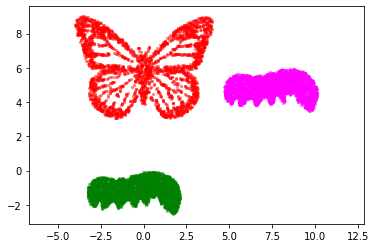

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
caterpillar = 1-import_img('caterpillar.png'); caterpillar/=caterpillar.max();
butterfly = 255-import_img('butterfly.jpg'); butterfly/=butterfly.max();
dset1 = ImageDataset(img=caterpillar*1,thresh=.8); 
dset2 = ImageDataset(img=butterfly*1,thresh=.8)

# n = 3000; dat1 = dset1.sample(n); dat2 = dset2.sample(n); dat3 = dset1.sample(n);
# dat1*=-1; dat2*=-1; dat1[:,1]-=1; dat2[:,1]+=5; dat3*=-1;
# dat3[:,0]+=8; dat3[:,1]+=6;

n = 3000; 
dat1 = dset1.sample(n); 
dat2 = dset2.sample(n); 
dat3 = dset1.sample(n);
dat1*=-1; dat2*=-1; dat1[:,1]-=1; dat2[:,1]+=5; dat3*=-1;
dat3[:,0]+=8; dat3[:,1]+=5;

plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='green')
plt.scatter(dat2.detach().numpy()[:,0],dat2.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='red')
plt.scatter(dat3.detach().numpy()[:,0],dat3.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='magenta')
plt.axis('equal')
plt.show() 

training with sinkhorn_small_reg
batch 0 loss tensor(2., device='cuda:0', grad_fn=<AddBackward0>)


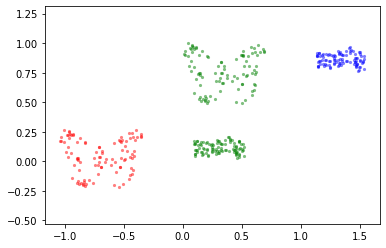

fit time  0.09773874282836914  reg loss time 0.00903463363647461
time elapsed 0.42983341217041016 total time 0.4288363456726074
batch number 0 out of 1500
batch 30 loss tensor(0.0495, device='cuda:0', grad_fn=<AddBackward0>)


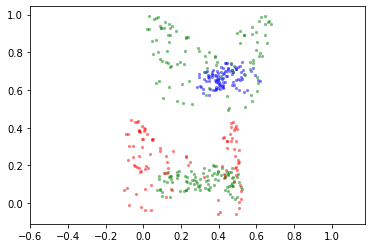

fit time  0.07579636573791504  reg loss time 0.009000062942504883
time elapsed 6.941253185272217 total time 11.710618734359741
batch number 30 out of 1500
batch 60 loss tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)


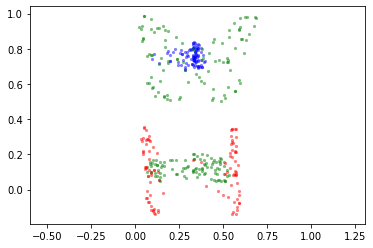

fit time  0.06382989883422852  reg loss time 0.007978677749633789
time elapsed 6.4105377197265625 total time 22.49693465232849
batch number 60 out of 1500
batch 90 loss tensor(0.0042, device='cuda:0', grad_fn=<AddBackward0>)


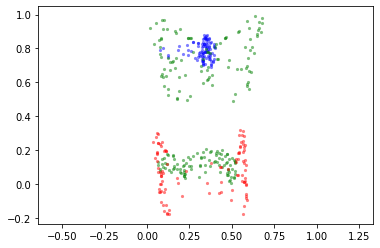

fit time  0.07896900177001953  reg loss time 0.008006095886230469
time elapsed 6.417845010757446 total time 33.39926624298096
batch number 90 out of 1500
batch 120 loss tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>)


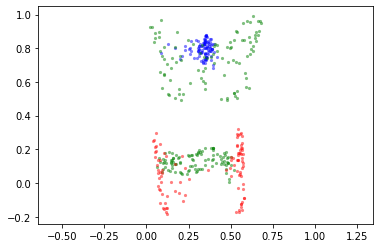

fit time  0.06672024726867676  reg loss time 0.007977962493896484
time elapsed 6.32555627822876 total time 44.156309604644775
batch number 120 out of 1500
batch 150 loss tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)


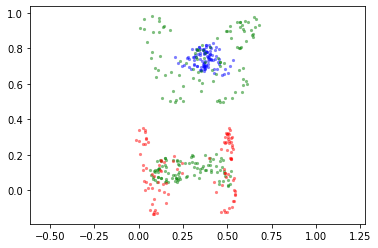

fit time  0.0638582706451416  reg loss time 0.007949113845825195
time elapsed 6.371785402297974 total time 54.88536524772644
batch number 150 out of 1500
batch 180 loss tensor(0.0041, device='cuda:0', grad_fn=<AddBackward0>)


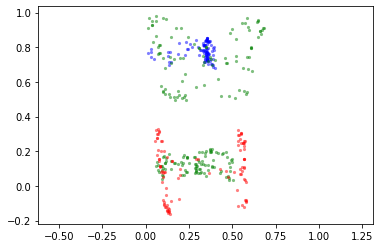

fit time  0.06781983375549316  reg loss time 0.008008956909179688
time elapsed 6.575855731964111 total time 65.98540592193604
batch number 180 out of 1500
batch 210 loss tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


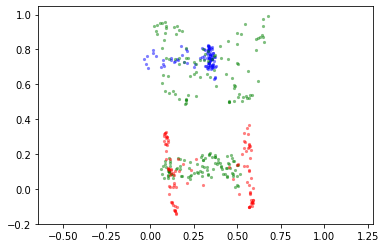

fit time  0.06295132637023926  reg loss time 0.007978677749633789
time elapsed 6.640461444854736 total time 77.12312364578247
batch number 210 out of 1500
batch 240 loss tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)


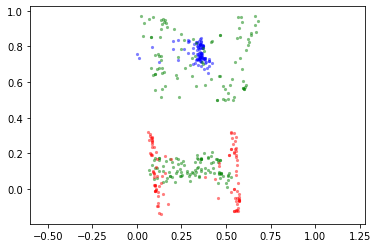

fit time  0.07035088539123535  reg loss time 0.00698089599609375
time elapsed 6.51846718788147 total time 87.88002014160156
batch number 240 out of 1500
batch 270 loss tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)


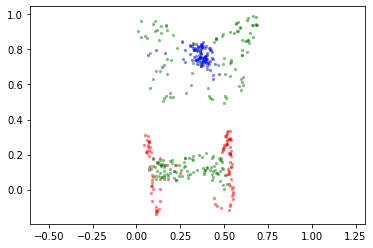

fit time  0.06598734855651855  reg loss time 0.007998228073120117
time elapsed 6.511825084686279 total time 98.8582649230957
batch number 270 out of 1500
batch 300 loss tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)


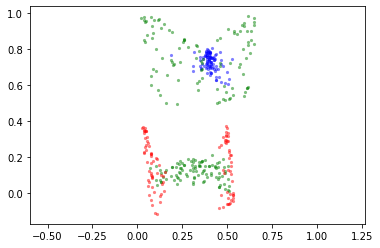

fit time  0.06781864166259766  reg loss time 0.006981849670410156
time elapsed 6.499276876449585 total time 109.74573349952698
batch number 300 out of 1500
batch 330 loss tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>)


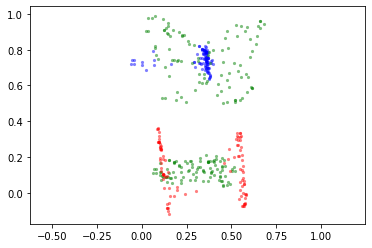

fit time  0.06517863273620605  reg loss time 0.006784677505493164
time elapsed 6.484121322631836 total time 120.38439345359802
batch number 330 out of 1500
batch 360 loss tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)


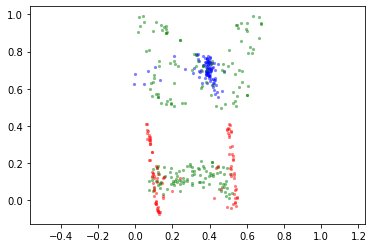

fit time  0.07081007957458496  reg loss time 0.00797891616821289
time elapsed 6.613955974578857 total time 131.21878027915955
batch number 360 out of 1500
batch 390 loss tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


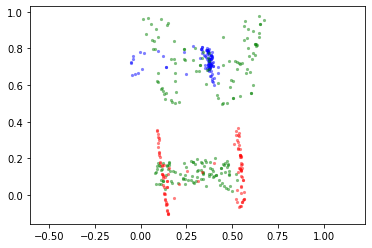

fit time  0.06425809860229492  reg loss time 0.007895469665527344
time elapsed 6.6075897216796875 total time 142.0186891555786
batch number 390 out of 1500
batch 420 loss tensor(0.0036, device='cuda:0', grad_fn=<AddBackward0>)


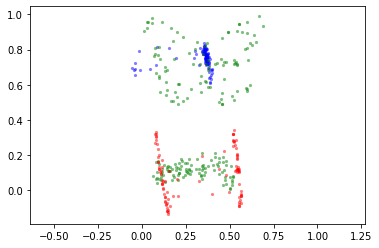

fit time  0.07081127166748047  reg loss time 0.008039236068725586
time elapsed 6.936007261276245 total time 153.1331491470337
batch number 420 out of 1500
batch 450 loss tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)


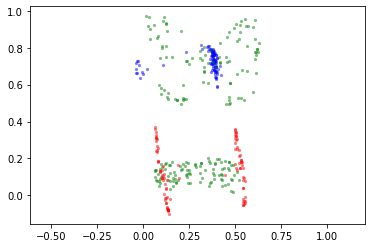

fit time  0.08280682563781738  reg loss time 0.0067484378814697266
time elapsed 7.708736419677734 total time 164.98565030097961
batch number 450 out of 1500
batch 480 loss tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)


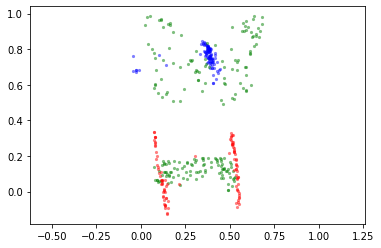

fit time  0.0718076229095459  reg loss time 0.006936550140380859
time elapsed 7.792246580123901 total time 176.9662799835205
batch number 480 out of 1500
batch 510 loss tensor(0.0082, device='cuda:0', grad_fn=<AddBackward0>)


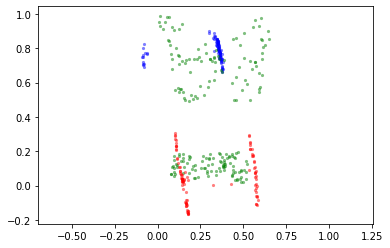

fit time  0.0748603343963623  reg loss time 0.0069255828857421875
time elapsed 7.83489727973938 total time 188.94186973571777
batch number 510 out of 1500
batch 540 loss tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)


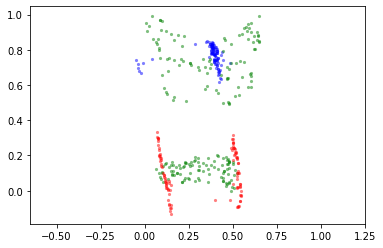

fit time  0.07588791847229004  reg loss time 0.006920576095581055
time elapsed 8.012341499328613 total time 201.01627254486084
batch number 540 out of 1500
batch 570 loss tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


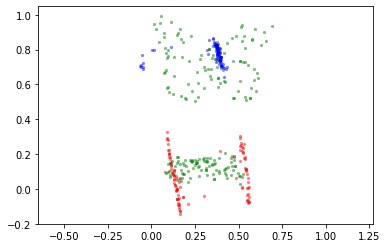

fit time  0.07679438591003418  reg loss time 0.007032155990600586
time elapsed 7.926638126373291 total time 213.07873702049255
batch number 570 out of 1500
batch 600 loss tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)


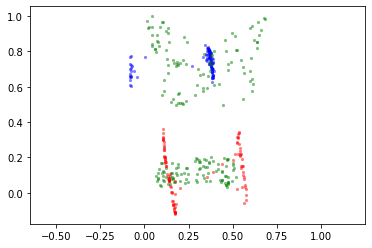

fit time  0.08078408241271973  reg loss time 0.006981372833251953
time elapsed 8.003414630889893 total time 225.32152104377747
batch number 600 out of 1500
batch 630 loss tensor(0.0045, device='cuda:0', grad_fn=<AddBackward0>)


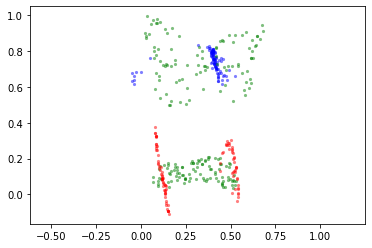

fit time  0.08627843856811523  reg loss time 0.0069179534912109375
time elapsed 8.209835529327393 total time 237.80915999412537
batch number 630 out of 1500
batch 660 loss tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


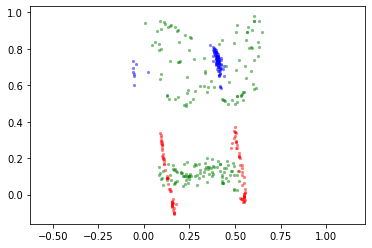

fit time  0.07682180404663086  reg loss time 0.0069806575775146484
time elapsed 8.763150930404663 total time 250.93530750274658
batch number 660 out of 1500
batch 690 loss tensor(0.0045, device='cuda:0', grad_fn=<AddBackward0>)


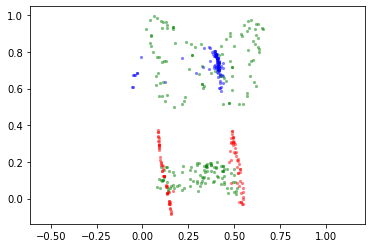

fit time  0.08577084541320801  reg loss time 0.007166862487792969
time elapsed 8.590905666351318 total time 263.79052901268005
batch number 690 out of 1500
batch 720 loss tensor(0.0047, device='cuda:0', grad_fn=<AddBackward0>)


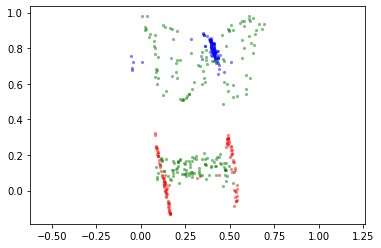

fit time  0.08876419067382812  reg loss time 0.0069811344146728516
time elapsed 8.613052368164062 total time 276.7388253211975
batch number 720 out of 1500
batch 750 loss tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)


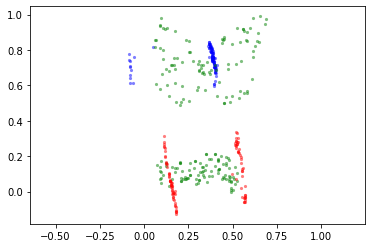

fit time  0.07642984390258789  reg loss time 0.006794452667236328
time elapsed 8.562790870666504 total time 289.77284049987793
batch number 750 out of 1500
batch 780 loss tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


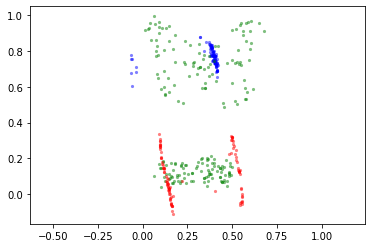

fit time  0.08676910400390625  reg loss time 0.006981849670410156
time elapsed 8.591140508651733 total time 302.48637342453003
batch number 780 out of 1500
batch 810 loss tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)


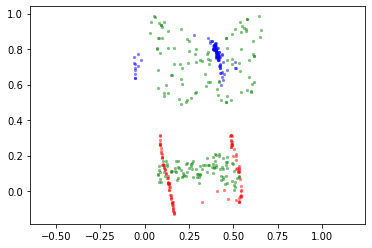

fit time  0.08975887298583984  reg loss time 0.00797891616821289
time elapsed 9.159178495407104 total time 315.8221254348755
batch number 810 out of 1500
batch 840 loss tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


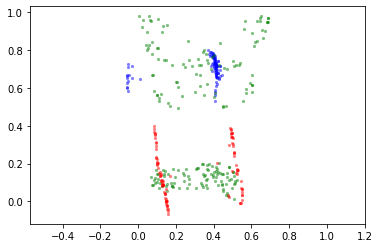

fit time  0.08477473258972168  reg loss time 0.008011817932128906
time elapsed 9.281998872756958 total time 329.5577530860901
batch number 840 out of 1500
batch 870 loss tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)


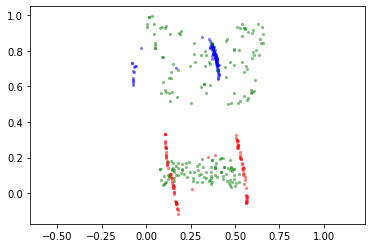

fit time  0.09278035163879395  reg loss time 0.0069522857666015625
time elapsed 9.20703125 total time 343.1945548057556
batch number 870 out of 1500
batch 900 loss tensor(0.0068, device='cuda:0', grad_fn=<AddBackward0>)


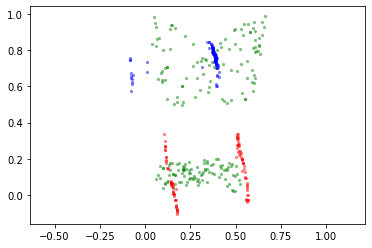

fit time  0.08579826354980469  reg loss time 0.0069539546966552734
time elapsed 9.298276662826538 total time 356.81395268440247
batch number 900 out of 1500
batch 930 loss tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)


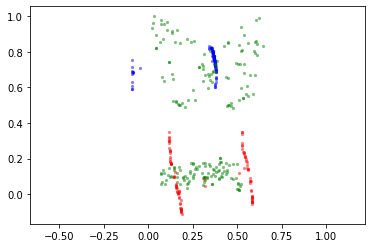

fit time  0.09624886512756348  reg loss time 0.00754094123840332
time elapsed 9.225158452987671 total time 370.229083776474
batch number 930 out of 1500
batch 960 loss tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)


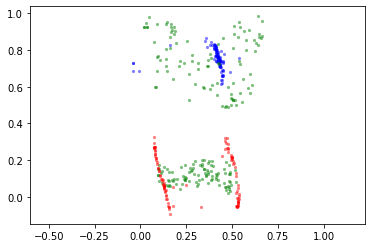

fit time  0.11170291900634766  reg loss time 0.0066487789154052734
time elapsed 9.57097864151001 total time 383.965904712677
batch number 960 out of 1500
batch 990 loss tensor(0.0039, device='cuda:0', grad_fn=<AddBackward0>)


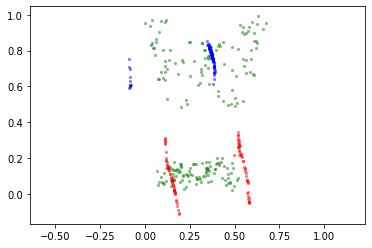

fit time  0.10272669792175293  reg loss time 0.00797891616821289
time elapsed 9.760104417800903 total time 397.9857840538025
batch number 990 out of 1500
batch 1020 loss tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)


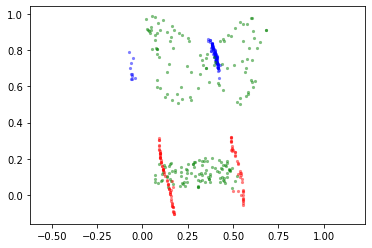

fit time  0.09976315498352051  reg loss time 0.007951021194458008
time elapsed 9.974979639053345 total time 412.1096258163452
batch number 1020 out of 1500
batch 1050 loss tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)


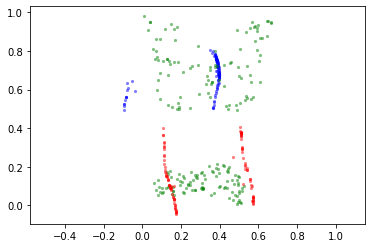

fit time  0.09674239158630371  reg loss time 0.007448911666870117
time elapsed 9.792550086975098 total time 426.3082232475281
batch number 1050 out of 1500
batch 1080 loss tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


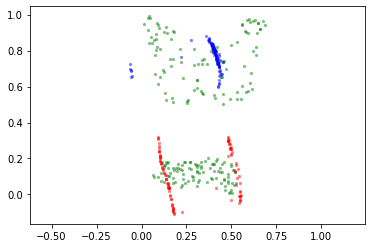

fit time  0.10372424125671387  reg loss time 0.007154226303100586
time elapsed 10.168411254882812 total time 440.65984320640564
batch number 1080 out of 1500
batch 1110 loss tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)


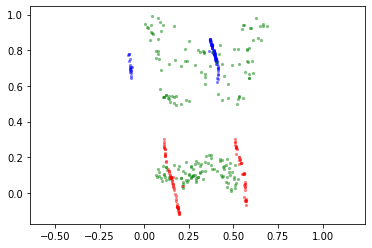

fit time  0.11069512367248535  reg loss time 0.006981372833251953
time elapsed 9.83247971534729 total time 454.62930035591125
batch number 1110 out of 1500
batch 1140 loss tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


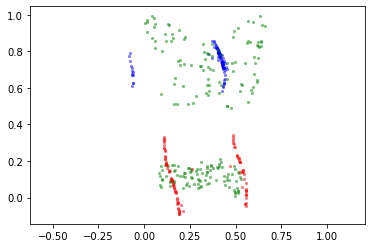

fit time  0.10574722290039062  reg loss time 0.0069506168365478516
time elapsed 9.872677326202393 total time 468.6722135543823
batch number 1140 out of 1500
batch 1170 loss tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)


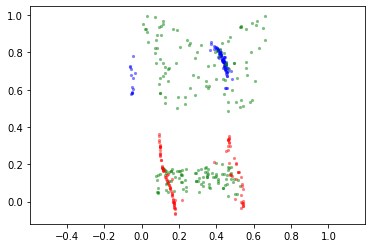

fit time  0.11324429512023926  reg loss time 0.0068683624267578125
time elapsed 10.330077886581421 total time 483.21789836883545
batch number 1170 out of 1500
batch 1200 loss tensor(0.0037, device='cuda:0', grad_fn=<AddBackward0>)


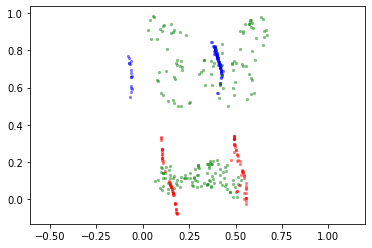

fit time  0.1047508716583252  reg loss time 0.007840871810913086
time elapsed 10.221834421157837 total time 497.7748098373413
batch number 1200 out of 1500
batch 1230 loss tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)


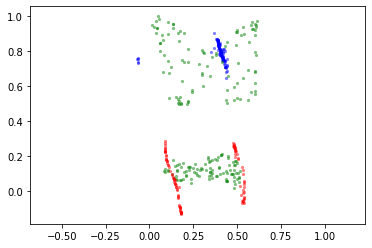

fit time  0.1072242259979248  reg loss time 0.007364511489868164
time elapsed 10.4603111743927 total time 512.3603465557098
batch number 1230 out of 1500
batch 1260 loss tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)


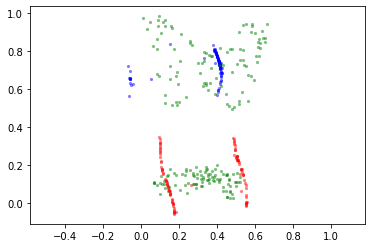

fit time  0.1077122688293457  reg loss time 0.007967233657836914
time elapsed 10.20276165008545 total time 526.6592078208923
batch number 1260 out of 1500
batch 1290 loss tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)


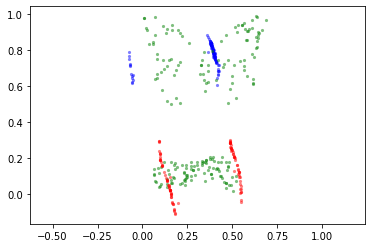

fit time  0.1102137565612793  reg loss time 0.006745576858520508
time elapsed 10.13285231590271 total time 541.0640144348145
batch number 1290 out of 1500
batch 1320 loss tensor(0.0092, device='cuda:0', grad_fn=<AddBackward0>)


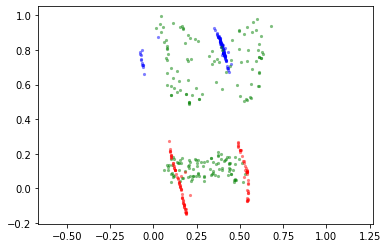

fit time  0.10871124267578125  reg loss time 0.007978439331054688
time elapsed 10.238818645477295 total time 555.4264073371887
batch number 1320 out of 1500
batch 1350 loss tensor(0.0032, device='cuda:0', grad_fn=<AddBackward0>)


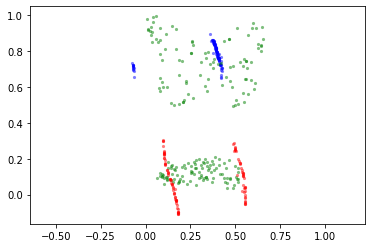

fit time  0.10272669792175293  reg loss time 0.00767207145690918
time elapsed 10.2232825756073 total time 569.9602015018463
batch number 1350 out of 1500
batch 1380 loss tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)


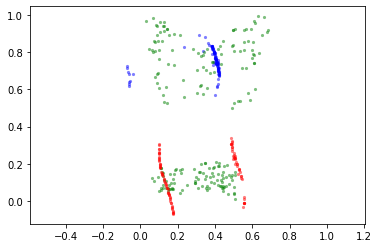

fit time  0.10835480690002441  reg loss time 0.006714344024658203
time elapsed 10.295387983322144 total time 584.4403264522552
batch number 1380 out of 1500
batch 1410 loss tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)


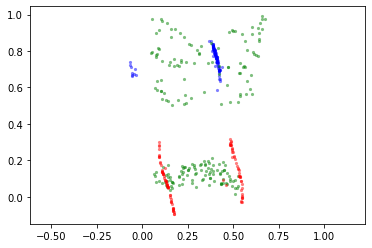

fit time  0.10073208808898926  reg loss time 0.006439208984375
time elapsed 10.33474349975586 total time 599.0200936794281
batch number 1410 out of 1500
batch 1440 loss tensor(0.0036, device='cuda:0', grad_fn=<AddBackward0>)


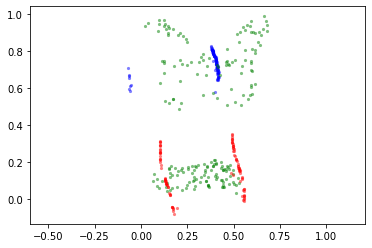

fit time  0.09876632690429688  reg loss time 0.0068738460540771484
time elapsed 10.318431377410889 total time 613.5309722423553
batch number 1440 out of 1500
batch 1470 loss tensor(0.0111, device='cuda:0', grad_fn=<AddBackward0>)


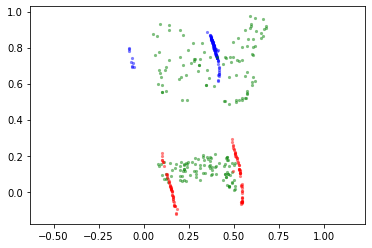

fit time  0.10674357414245605  reg loss time 0.008032560348510742
time elapsed 10.278976440429688 total time 628.0923433303833
batch number 1470 out of 1500


<Figure size 432x288 with 0 Axes>

In [11]:
dat_tuple = (dat1,dat2)
z_target = torch.stack(dat_tuple).to(device)
model = FfjordModel(); 
# model.load_state('models/seq_state420_time_31.615391731262207.tar');
# model.load_state('models/state310_time_22.49951934814453.tar');
# model.load_state('models/state_4980_time_52.544029712677_0.026161890476942062.tar');
# for my_loss in ['sinkhorn_small_reg']:
my_loss = 'sinkhorn_small_reg'
    # %prun 
model, losses, separate_losses = learn_trajectory(z_target, my_loss=my_loss,n_iters=1500,n_subsample=100, model=model, save=True)

In [11]:
save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000,reverse=True)

<Figure size 432x288 with 0 Axes>

In [ ]:
# Example with 3 timesteps
dset = ImageDataset(img=make_image())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dat = dset.sample(512)
dat2 = torch.add(dat,torch.tensor([10,-10]))
dat3 = torch.add(dat,torch.tensor([20,0]))
dat_tuple = (dat,dat2,dat3)
z_target = torch.stack(dat_tuple).to(device)

# for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg']:
for my_loss in ['sinkhorn_small_reg']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_iters=10,n_subsample=100)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)

In [ ]:
# Example with 2 timesteps
dset = ImageDataset(img=make_image())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dat = dset.sample(512)
dat2 = torch.add(dat,torch.tensor([10,-10]))

dat_tuple = (dat,dat2)
z_target = torch.stack(dat_tuple).to(device)

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=1000)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
#trying other shapes

square = np.zeros([20,20])
square[6:14,:8] = 1

two_square = np.zeros([20,20])
two_square[:5,14:] = 1
two_square[15:,14:] = 1


annulus = import_img('annulus.png')
circle = 255-import_img('circle.jpeg')

dset = ImageDataset(img=square)
dset1 = ImageDataset(img=two_square)

n = 500
dat = dset.sample(n)
dat1 = dset1.sample(n)
plt.scatter(dat.detach().numpy()[:,0],dat.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='red')
plt.show() 

In [ ]:
# make half moon dataset
import sklearn.datasets

moons, labels = sklearn.datasets.make_moons(n,noise=.1) #generates two half moons
mask = (labels == 0)
one_moon = moons[mask,:] # only keep one moon

def rot_mat(theta0):
    #computes rotation matrix of angle theta
    return np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])

theta0 = np.pi/2
theta1 = np.pi

rot0 = rot_mat(theta0)
rot1 = rot_mat(theta1)

# apply rotation to the moon
one_moon_rot0 = np.dot(one_moon,rot0)
one_moon_rot1 = np.dot(one_moon,rot1)

In [ ]:
#visualize rotated moons

plt.scatter(one_moon[:,0],one_moon[:,1], color='blue')
plt.scatter(one_moon_rot0[:,0],one_moon_rot0[:,1], color='orange')
plt.scatter(one_moon_rot1[:,0],one_moon_rot1[:,1], color='green')

In [ ]:
# with three timesteps

dat = torch.tensor(one_moon,dtype=torch.float)
dat0 = torch.tensor(one_moon_rot0,dtype=torch.float)
dat1 = torch.tensor(one_moon_rot1,dtype=torch.float)

dat_tuple = (dat,dat0,dat1)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
# with two timesteps


dat_tuple = (dat,dat0)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
files = os.listdir('models/');
losses = [None] * 500;
# i=0
for i in range(len(files)):
# for i in range(5):
    ind = int(int(files[i].split("_")[0][5:])/10);
    print(ind, files[i])
    model = FfjordModel(); 
    model.load_state('models/'+files[i]); model.to(device)
    m, loss = learn_trajectory(z_target, my_loss, n_iters = 1, n_subsample = 1000, model=model, save=False)
#     save_trajectory(model,z_target,my_loss+str(ind), savedir='imgs', nsteps=101, memory=0.01, n=1000)
#     save_trajectory(model,z_target,my_loss+str(ind), savedir='imgs', nsteps=101, memory=0.01, n=1000,reverse=True)
    losses[ind]=loss[0]
    

In [ ]:
# plt.plot(losses[100:]); 
# plt.plot(separate_losses[0,50:]); 
# plt.plot(separate_losses[1,50:]); 
plt.plot(separate_losses[2,50:]); 
plt.plot(separate_losses[3,50:]); 
plt.plot(separate_losses[4,50:]); 
plt.plot(separate_losses[5,50:]); 
# plt.plot(separate_losses[6,0:]);
plt.show()

In [ ]:
losses